Notebook by Zara

## **Faster R-CNN on custom dataset**

Experiment 4: simplified model architecture + anchor boxes

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models  # Import models from TensorFlow
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

``Read data and folder path``

In [2]:
data = pd.read_excel('/Users/zaravanthoff/Desktop/data/annotations_cleaned_more.xlsx')

In [3]:
folder_path = "/Users/zaravanthoff/Desktop/data/images"

In [4]:
data

,Brand,Image,Xmin,Xmax,Ymin,Ymax,Class,ObjectWidth,ObjectHeight,Image Width,Image Height
0,ABN AMRO,1843248.JPG,1755,2385,4452,4649,0,630,197,3409,4900
1,ABN AMRO,1820597.JPG,1589,2212,4320,4590,0,623,270,3152,4708
2,ABN AMRO,1818130.JPG,2346,3038,2011,2189,0,692,178,3114,2230
3,ABN AMRO,18637600_01.JPG,2032,2423,2940,3042,0,391,102,2608,3232
4,ABN AMRO,1814797.JPG,2991,3102,392,506,0,111,114,3147,539
...,...,...,...,...,...,...,...,...,...,...,...
590,TUI,1844444.JPG,145,1941,9,1150,16,1796,1141,3193,2207
591,TUI,18614610_01.JPG,2695,3047,100,261,16,352,161,3146,2200
592,TUI,1854527.JPG,1160,1349,58,151,16,189,93,1422,1029
593,TUI,18606990_01.JPG,2699,3043,106,268,16,344,162,3147,2203


``Preprocess data``

**Resizing**

In [5]:
import cv2
import os
import pandas as pd
import numpy as np

def preprocess_data(data, folder_path, target_width=416, target_height=416):
    """
    Preprocesses images and labels from the given DataFrame.
    
    Args:
        data (DataFrame): DataFrame containing image filenames, labels, and bounding box coordinates.
        folder_path (str): Path to the folder containing the images.
        target_width (int): Target width for resizing the images.
        target_height (int): Target height for resizing the images.
    
    Returns:
        tuple: Tuple containing preprocessed images, labels, and adjusted bounding box coordinates.
    """
    resized_images = []
    labels = []
    adjusted_bboxes = []  # List to store adjusted bounding box coordinates

    # Iterate through each row in the dataset
    for index, row in data.iterrows():
        # Extract image filename from the dataset
        image_filename = row['Image']  # Accessing by column name
        
        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_filename)
        
        try:
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            
            # Check if the image was read successfully
            if image is None:
                raise FileNotFoundError(f"Unable to read image at path: {image_path}")
            
            # Resize the image to the target size
            resized_image = cv2.resize(image, (target_width, target_height))
            
            # Append resized image to the list
            resized_images.append(resized_image)
            
            # Append label to the list (assuming label is in the 'Class' column of the dataframe)
            label = row['Class']
            labels.append(label)
            
            # Adjust bounding box coordinates
            xmin = int(row['Xmin'] * (target_width / image.shape[1]))
            ymin = int(row['Ymin'] * (target_height / image.shape[0]))
            xmax = int(row['Xmax'] * (target_width / image.shape[1]))
            ymax = int(row['Ymax'] * (target_height / image.shape[0]))
            adjusted_bboxes.append((xmin, ymin, xmax, ymax))
            
            print(f"Image processed successfully: {image_filename}")
        except Exception as e:
            print(f"Error processing image at path {image_path}: {str(e)}")

    return np.array(resized_images), np.array(labels), np.array(adjusted_bboxes)

def compute_bbox_deltas(data, adjusted_bboxes):
    """
    Computes bounding box deltas based on adjusted bounding box coordinates and ground truth bounding box coordinates.

    Args:
        data (DataFrame): DataFrame containing ground truth bounding box coordinates.
        adjusted_bboxes (numpy array): Array containing adjusted bounding box coordinates.

    Returns:
        numpy array: Array containing bounding box deltas.
    """
    bbox_deltas = []
    for index, row in data.iterrows():
        xmin_true = row['Xmin']
        ymin_true = row['Ymin']
        xmax_true = row['Xmax']
        ymax_true = row['Ymax']

        xmin_adjusted, ymin_adjusted, xmax_adjusted, ymax_adjusted = adjusted_bboxes[index]

        dx = (xmin_true - xmin_adjusted) / (xmax_true - xmin_adjusted)
        dy = (ymin_true - ymin_adjusted) / (ymax_true - ymin_adjusted)
        dw = np.log((xmax_true - xmin_true) / (xmax_adjusted - xmin_adjusted))
        dh = np.log((ymax_true - ymin_true) / (ymax_adjusted - ymin_adjusted))

        bbox_deltas.append([dx, dy, dw, dh])

    return np.array(bbox_deltas)

In [ ]:
# Preprocess images and labels
resized_images, labels, adjusted_bboxes = preprocess_data(data, folder_path)

**Normalize pixels**

In [ ]:
# Normalize pixel values
resized_images = resized_images.astype('float32') / 255.0

# Check the range of pixel values after normalization
print("Minimum Pixel Value After Normalization:", np.min(resized_images))
print("Maximum Pixel Value After Normalization:", np.max(resized_images))

**Augmentation**

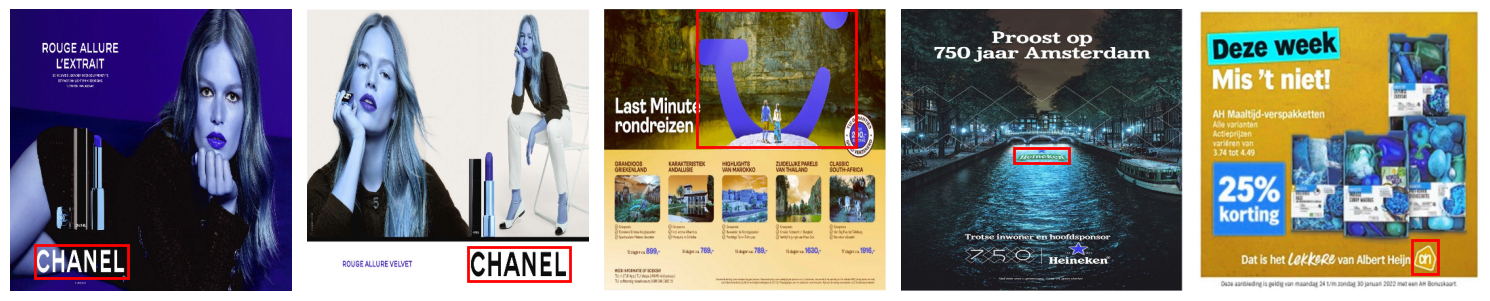

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa

def augment_and_visualize(images, adjusted_bboxes):
    """
    Applies data augmentation to a batch of images and adjusted bounding box coordinates,
    and visualizes a random sample of 5 augmented images with their adjusted bounding boxes.

    Args:
        images (numpy array): Array of preprocessed images (dtype: float32 or other).
        adjusted_bboxes (numpy array): Array of adjusted bounding box coordinates (dtype: int64).

    Returns:
        tuple: Tuple containing augmented images and corresponding adjusted bounding box coordinates.
    """
    # Convert images to uint8
    images = (images * 255).astype(np.uint8)

    # Define augmentation sequence
    seq = iaa.Sequential([
        # iaa.Fliplr(0.5),  # 50% horizontal flips
        # iaa.Affine(rotate=(-10, 10)),  # rotate by -10 to 10 degrees
        # iaa.Multiply((0.8, 1.2)),  # brightness change
        # iaa.GaussianBlur(sigma=(0.0, 3.0)),  # Gaussian blur
        # iaa.Dropout(p=(0, 0.2)),  # random dropout of pixels
        # iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Gaussian noise
        # iaa.LinearContrast((0.8, 1.2)),  # linear contrast adjustment
        # iaa.Grayscale(alpha=(0.0, 1.0)),  # convert to grayscale with varying intensity
        # iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),  # elastic transformation
        # iaa.PerspectiveTransform(scale=(0.01, 0.1)),  # random perspective transform
        # iaa.Cutout(nb_iterations=(1, 3), size=(0.1, 0.2), squared=False)  # random cutout
    ])

    # List to store resized images and new adjusted bounding boxes
    resized_images = []
    new_adjusted_bboxes = []

    # Iterate over each image and its corresponding bounding box
    for i in range(len(images)):
        image = images[i]
        bbox = adjusted_bboxes[i]

        # Convert bounding box to BoundingBoxesOnImage format
        bbox_list = [BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])]
        bbs = BoundingBoxesOnImage(bbox_list, shape=image.shape)

        # Apply augmentation to both image and bounding box
        aug_result = seq(image=image, bounding_boxes=bbs)

        # Unpack the augmented image and bounding box annotations from the tuple
        resized_image, augmented_bbs = aug_result

        # Extract adjusted bounding box coordinates
        adjusted_bbox = [
            augmented_bbs.bounding_boxes[0].x1_int,
            augmented_bbs.bounding_boxes[0].y1_int,
            augmented_bbs.bounding_boxes[0].x2_int,
            augmented_bbs.bounding_boxes[0].y2_int
        ]

        # Append resized image and adjusted bounding box to the lists
        resized_images.append(resized_image)
        new_adjusted_bboxes.append(adjusted_bbox)

    # Convert lists to numpy arrays
    resized_images = np.array(resized_images)
    new_adjusted_bboxes = np.array(new_adjusted_bboxes)

    # Visualize a random sample of 5 augmented images with their adjusted bounding boxes
    visualize_sample(resized_images, new_adjusted_bboxes, sample_size=5)

    return resized_images, new_adjusted_bboxes

def visualize_sample(images, adjusted_bboxes, sample_size=5):
    """
    Visualizes a random sample of augmented images along with their adjusted bounding boxes.

    Args:
        images (numpy array): Array of augmented images.
        adjusted_bboxes (numpy array): Array of adjusted bounding box coordinates.
        sample_size (int): Number of images to visualize (default: 5).
    """
    # Randomly select indices for the sample
    sample_indices = np.random.choice(len(images), sample_size, replace=False)

    # Create figure and axes for visualization
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))

    # Iterate over sample indices and plot images with bounding boxes
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        image = images[idx]
        bbox = adjusted_bboxes[idx]

        # Plot image
        ax.imshow(image)
        ax.axis('off')

        # Plot adjusted bounding box
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming resized_images and adjusted_bboxes are populated with data
augmented_images, augmented_bboxes = augment_and_visualize(resized_images, adjusted_bboxes)

``Little more cleaning (inconsistencies in data and data types)``

In [ ]:
# Check the shape of augmented images and bounding boxes
print("Shape of Augmented Images:", augmented_images.shape)
print("Shape of Augmented Bounding Boxes:", augmented_bboxes.shape)

In [ ]:
print("Length of resized_images:", len(augmented_images))
print("Length of labels:", len(labels))
print("Length of adjusted_bboxes:", len(augmented_bboxes))

In [ ]:
print("Type of resized_images:", type(augmented_images))
print("Type of labels:", type(labels))
print("Type of adjusted_bboxes:", type(augmented_bboxes))

In [ ]:
import numpy as np

# Convert lists to NumPy arrays
resized_images = np.array(augmented_images)
labels = np.array(labels)
adjusted_bboxes = np.array(augmented_bboxes)

# Check the types of the converted arrays
print("Type of resized_images_np:", type(augmented_images))
print("Type of labels_np:", type(labels))
print("Type of adjusted_bboxes_np:", type(augmented_bboxes))

``Split train/test/validation with stratified sampling and shuffling``

To incorporate stratified sampling into the data splitting, I use the 'stratify' parameter available in the 'train_test_split' function from 'sklearn.model_selection'. This parameter ensures that the class distribution is maintained across the training, validation, and test sets. 

Before the stratified sampling, shuffling is incoporated to introduce randomness and prevent bisases that may arise. By shuffing data first, we ensure that each subset gets a random mix of examples from all classes. 

In [13]:
# Shuffle the data and labels together
shuffle_indices = np.random.permutation(len(augmented_images))
shuffled_images = augmented_images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]
shuffled_bboxes = augmented_bboxes[shuffle_indices]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the shuffled data into training (80%) and temporary (20%) sets
train_data, temp_data, train_labels, temp_labels, train_bboxes, temp_bboxes = train_test_split(
    shuffled_images, shuffled_labels, shuffled_bboxes, test_size=0.2, random_state=42, stratify=shuffled_labels)

# Split the temporary set into validation (50%) and test (50%) sets
val_data, test_data, val_labels, test_labels, val_bboxes, test_bboxes = train_test_split(
    temp_data, temp_labels, temp_bboxes, test_size=0.5, random_state=42, stratify=temp_labels)

# Check the sizes of the splits
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
# Convert class labels to one-hot encoded vectors
num_classes = 17  # Number of classes in your dataset
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


# Verify the shape of the one-hot encoded labels
print("Shape of train_labels_one_hot:", train_labels.shape)
print("Shape of val_labels_one_hot:", val_labels.shape)
print("Shape of test_labels_one_hot:", test_labels.shape)

``Model architecture``

**Backbone and Region Proposal Network (RPN)**

This code is a function for generating anchor boxes. These are predefined bounding boxes of different sizes and aspect ratios that are tiles over the image at various positions. These anchor boxes serve as reference boxes for detecting objects of interest during training.

Input parameters:
- feature_map: this is the ouput feature map from the backbone network.
- scales: a list of scales representing the sizes of the anchor boxes.
- aspect_ratios: a list of tuples representing the aspect ratios (width-to-height ratios) of th anchor boxes. 

Output: 

anchor_boxes: a tensor containing the generated anchor boxes. Each anchor box is represented by four values x_min, y_min, x_max, y_max, denoting the coordinates of the top-left and bottom-right corners of the box. 

Function steps:
1. Initilization: 
- Determine the number of anchor boxes to generate based on the provided 'scales' and 'aspect_ratios'.
- Get the dimensions (height, width, channels) of the feature_map.
2. Generating anchor boxes:
- Iterate over each scale and aspect ratio combination.
- For each combination, calculate the width (w) and height (h) of the anchor box.
- Generate a grid of center coordinates covering the entire feature map using np.linspace and np.meshgrid.
- Compute the coordinates of the anchor boxes based on the center coordinates, width, and height. 
- Stack the anchor boxes for each scale and aspect ratio combination into a list. 
3. Reshaping:
- Stack the list of anchor boxes into a 3D array where the first dimension corresponds to different anchor boxes.
- Reshape the anchor_boxes array into a 2D tensor where each row represents an anchor box with coordinates.


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Input
import numpy as np

# Function to generate anchor boxes
def generate_anchor_boxes(feature_map, scales, aspect_ratios):
    """
    Generates anchor boxes for the given feature map.

    Args:
        feature_map (tensor): Output feature map from the backbone network.
        scales (list): List of anchor box scales.
        aspect_ratios (list): List of anchor box aspect ratios.

    Returns:
        tensor: Tensor containing anchor boxes.
    """
    num_anchors = len(scales) * len(aspect_ratios)
    height, width, channels = feature_map.shape[1:]

    # Generate anchor boxes based on scales and aspect ratios
    anchor_boxes = []
    for scale in scales:
        for aspect_ratio in aspect_ratios:
            w = scale * aspect_ratio[0]
            h = scale * aspect_ratio[1]
            # Generate center coordinates of the anchor boxes
            x_center = np.linspace(0, width - 1, width)
            y_center = np.linspace(0, height - 1, height)
            x_center, y_center = np.meshgrid(x_center, y_center)
            x_center = np.ravel(x_center)
            y_center = np.ravel(y_center)

            # Create anchor boxes
            anchor_box = np.stack([
                x_center - w / 2,
                y_center - h / 2,
                x_center + w / 2,
                y_center + h / 2
            ], axis=-1)

            anchor_boxes.append(anchor_box)

    # Reshape anchor boxes to match the tensor shape
    anchor_boxes = np.stack(anchor_boxes, axis=0)
    anchor_boxes = np.reshape(anchor_boxes, (-1, 4))

    return anchor_boxes

- The ResNet-50 bakcbone is loaded with the weights='imagenet' arguement to initialize the model with pre-trained ImageNet weights. 
- The include_top=False argument ensures that the top (fully connected) layers are excluded, leaving only the convolutional feature extraction layers. 
- The code feezes (sets trainable=False) the convolutional layers. This prevents their weights from being updated during training, allowing us to use the pre-trained model as a fixed feature extractor. 

The RPN proposes candidate object regions (anchor boxes) for further refinement and classification. It is the first stage of a typical two-stage object detection pipeline like Faster R-CNN.

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16


# Load pre-trained VGG-16 model without including the top (fully connected) layers
input_image = Input(shape=(416, 416, 3))

# Load pre-trained ResNet-50 model without including the top (fully connected) layers
resnet_backbone = ResNet50(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# Freeze the convolutional layers of the ResNet-50 backbone
for layer in resnet_backbone.layers:
    layer.trainable = False

# # Load pre-trained VGG-16 model without including the top (fully connected) layers
# vgg_backbone = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# # Freeze the convolutional layers of the VGG-16 backbone
# for layer in vgg_backbone.layers:
#     layer.trainable = False

# Define the input tensor for the RPN
rpn_input = resnet_backbone.output  # Output of the VGG-16 backbone

# Add convolutional layers for the RPN
rpn_conv = Conv2D(256, (3, 3), padding='same', activation='relu', name='rpn_conv')(rpn_input)

# Define anchor box parameters
scales = [32, 64, 128]  # Anchor box scales (in pixels)
aspect_ratios = [(1, 1), (1, 2), (2, 1)]  # Anchor box aspect ratios

# Generate anchor boxes
anchor_boxes = generate_anchor_boxes(rpn_conv, scales, aspect_ratios)

# Apply objectness and bounding box regression layers
# Objectness scores is the probability of an object being present
objectness_scores = Conv2D(len(scales) * len(aspect_ratios) * 2, (1, 1), activation='sigmoid', name='objectness_scores')(rpn_conv)
# Bounding box deltas values are for adjusting the anchor boxes
bbox_deltas = Conv2D(len(scales) * len(aspect_ratios) * 4, (1, 1), activation='linear', name='bbox_deltas')(rpn_conv)

# Define the RPN model
rpn_model = tf.keras.Model(inputs=resnet_backbone.input, outputs=[objectness_scores, bbox_deltas])


**Region of Interest Pooling (ROI)**

Strategies:
1. Pooling layer size and strategy: Evaluate the effectiveness of using MaxPooling2d with a fixes pool size (e.g., (2, 2)). Depending on the specific application and input data characteristics, experimenting with different pool sizes or adaptive pooling strategies (e.g., adaptive max pooling) might be beneficial. 
2. Feature concatenation: ensure that concatenation of pooled features (Concatenate(axis=-1)) aligns with the desires feature representation. You may need to experiment with different concatenation axes or methods (e.g., summing instead of concatenation) to optimize feature aggregation.
3. Flattening and dense layers: Consider the complexity and size of your fully connected layers (Dense). The number of neurons (1024 in your case) and the depth of the network can impact model performance. You might try adjusting the number of neurons, adding dropout layers for regularization, or experimenting with different activations functions. 
4. Regularization and Batch Normalization:Implement regularization techniques such as dropout (Dropout) or L2 regularization to prevent overfitting. Additionally, batch normalization (BatchNormalization) can help stabilize training and improve generalization.
5. Learning Rate and Optimization: Experiment with different optimizers (Adam, SGD, etc.) and learning rates to find the optimal training configuration for your model. Monitor training/validation loss and accuracy to assess convergence and overfitting.


Modifications in code:

1. 'Batchnormalization' layers are added after each 'MaxPooling2D' layer to stabilize training and improve generalization.
2. 'Dropout' layers are insterted before dense layers to introduce regularization.
3. The number of neurons in the dense layers (512 instead of 1024) is reduced, and dropout is used. 

Explanation of the code

The roi_model performs Region of Interest (ROI) pooling and subsequent classification and bounding box regression tasks based on the output of the RPN. 

1. Input and output setup: the input tensor is set to the first output of the RPN model, representing obejct proposals gereated by the RPN.
2. ROI pooling layer: for each output tensor from the RPN a MaxPooling2D layer with a pool size of (2,2) is added followed by Batchnormalization to downsample and normalize the features. 
3. Concatenatrion and flattening: the pooled features from all RPN outputs are concatenated along the channel axis and are then flattened to prepare for input into fully connected layers. Flattening is reshaping a multi-demnsional array into a format that can be used as input to fully connected layers.
4. Fully connected layers (dense layers):
- Feature transformation: the flattened ROI pooled features are passed through fully connected (dense) layers (fc1, fc2) with ReLU activation to transform the feature representation. Fc layers are a type of layer in nn where each neuron or node in a layer is connected to every neuron in the preceding layers. Every input to the layer is connected to every neuron, and ecah connection is associated with a weight that is learned during training. 
- Dropout regularization: dropout layers are applied after each fully connected layer to mitigate overfitting during training. 
5. Outputs: the model outputs include the classification probabilities and bounding box regression offsets. 


In [18]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

# Define input tensor for ROI pooling
roi_input = rpn_model.output[0]  # Output of the RPN model

# Add a 2x2 MaxPooling2D layer with BatchNormalization for each output of the RPN model
pooling_layers = []
for output_tensor in rpn_model.output:
    pooling_layer = MaxPooling2D(pool_size=(2, 2))(output_tensor)
    pooling_layer = BatchNormalization()(pooling_layer)  # Add BatchNormalization
    pooling_layers.append(pooling_layer)

# Concatenate the pooled features along the channel axis
roi_pooling = Concatenate(axis=-1)(pooling_layers)

# Flatten the ROI pooled features
flattened_roi = Flatten()(roi_pooling)

# Add fully connected layers with Dropout for classification and regression
fc1 = Dense(128, activation='relu')(flattened_roi) #hiervoor: 512
fc1 = Dropout(0.5)(fc1)  # Add Dropout 50% chance by randomly setting a fraction of input units to zero during training
fc2 = Dense(128, activation='relu')(fc1) #hiervoor: 512
fc2 = Dropout(0.5)(fc2)  # Add Dropout

# Output layer for classification
num_classes = 17  # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(fc2)

# Output layer for bounding box regression
regression_output = Dense(4, activation='linear', name='regression')(fc2)

# Define input and output tensors for the ROI pooling model
roi_model = Model(inputs=rpn_model.input, outputs=[classification_output, regression_output])


**Bounding box regression and classification**

Changes:
1. Shared Layers for Efficiency: Instead of independently applying Flatten() and subsequent dense layers to the RPN output twice (once for classification and once for regression), you can share some of the layers to make the model more efficient. This reduces redundant computations and potentially improves training stability.
2. Layer Reuse: Reuse the same shared layers for both tasks (classification and bounding box regression) to promote feature reuse and reduce overfitting. For example, define common dense layers (Dense(512, activation='relu')) once and use them for both classification and regression tasks.

Explanation of the code

This piece of code constructs the final model for object detection for incoporating both bounding box regression and object classifcation based on the output of the RPN.


In [19]:
from tensorflow.keras.layers import Flatten, Dense

# Assuming rpn_model.output is a tuple containing multiple tensors
rpn_output_tensor = rpn_model.output[0]  # Choose the first tensor from the tuple

# Flatten the output of the RPN
rpn_output_flattened = Flatten()(rpn_output_tensor)

# Add fully connected layers for bounding box regression
bbox_regression_fc1 = Dense(128, activation='relu')(rpn_output_flattened)
bbox_regression_fc2 = Dense(128, activation='relu')(bbox_regression_fc1)
bbox_deltas_output = Dense(4, activation='linear', name='bbox_deltas')(bbox_regression_fc2)  # Output layer for bounding box regression

# Add fully connected layers for object classification
classification_fc1 = Dense(128, activation='relu')(rpn_output_flattened)
classification_fc2 = Dense(128, activation='relu')(classification_fc1)
num_classes = 17 # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(classification_fc2)  # Output layer for classification

# Define input and output tensors for the model
final_model = tf.keras.Model(inputs=rpn_model.input, outputs=[classification_output, bbox_deltas_output])

# Print the summary of the final model
# final_model.summary()

**Loss function**

Explanation of the code: 
- RPN classification loss: This function computes the binary cross-entropy loss for the predicted objectness scores (probabilities). It first filters out the "neutral" anchors (-1 labels), which are not used for training. The final loss value is computed by the mean of the loss tensor.
- RPN regression loss: This function computes the smooth L1 loss for the predicted bounding box deltas in the RPN. Similar to the classification loss, it filters out the "neutral" anchors and then calculates the smooth L1 loss. The final loss value is computed by the mean of the loss tensor.
- RCNN classification loss: this function computes the categorical cross-entropy loss for the predicted class probabilities in the RCNN. It calculates the loss between the true one-hote encoded labels and predicted class probabilities.
- RCNN regression loss: it this function computes the smooth L1 loss for the predicted bounding box deltas in the RCNN.
- Total loss function: this function combines the individual losses into a single loss value for training. 


Categorical and Binary Cross-Entropy Loss are common loss functions in machine learning, particularly for classification tasks. 

In [20]:
import tensorflow as tf

def rpn_classification_loss(y_true, y_pred):
    # y_true: true labels (1 for positive anchors, 0 for negative anchors, -1 for neutral anchors)
    # y_pred: predicted probabilities for objectness scores (softmax output)
    if tf.sparse.is_sparse(y_true):
        print("y_true is a SparseTensor")
    else:
        print("y_true is not a SparseTensor")
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(y_true, -1))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute binary cross-entropy loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rpn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(tf.reduce_sum(tf.abs(y_true), axis=1), 0))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_classification_loss(y_true, y_pred):
    # y_true: true class labels (one-hot encoded)
    # y_pred: predicted class probabilities
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

# Combine the losses for RPN and RCNN
def total_loss(y_true, y_pred):
    rpn_cls_true, rpn_reg_true, rcnn_cls_true, rcnn_reg_true = y_true
    rpn_cls_pred, rpn_reg_pred, rcnn_cls_pred, rcnn_reg_pred = y_pred
    
    rpn_cls_loss = rpn_classification_loss(rpn_cls_true, rpn_cls_pred)
    rpn_reg_loss = rpn_regression_loss(rpn_reg_true, rpn_reg_pred)
    rcnn_cls_loss = rcnn_classification_loss(rcnn_cls_true, rcnn_cls_pred)
    rcnn_reg_loss = rcnn_regression_loss(rcnn_reg_true, rcnn_reg_pred)
    
    total_loss = rpn_cls_loss + rpn_reg_loss + rcnn_cls_loss + rcnn_reg_loss
    
    return total_loss

``Training``

Strategies: adjusting learning rate to specific model specs

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(images, labels_true, labels_pred, bboxes_true, bboxes_pred, num_samples=3):
    """
    Visualize predicted bounding boxes on sample images during training.

    Args:
        images (numpy array): Array of images.
        labels_true (numpy array): True class labels (one-hot encoded).
        labels_pred (numpy array): Predicted class labels (one-hot encoded).
        bboxes_true (numpy array): True bounding box coordinates (xmin, ymin, xmax, ymax).
        bboxes_pred (numpy array): Predicted bounding box coordinates (xmin, ymin, xmax, ymax).
        num_samples (int): Number of samples to visualize (default: 3).
    """
    # Select random samples for visualization
    sample_indices = np.random.choice(len(images), num_samples, replace=False)

    # Create subplots for visualization
    fig, axes = plt.subplots(num_samples, figsize=(8, 6*num_samples))

    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        image = images[idx]
        label_true = labels_true[idx]
        label_pred = labels_pred[idx]
        bbox_true = bboxes_true[idx]
        bbox_pred = bboxes_pred[idx]

        # Plot image
        ax.imshow(image)
        ax.axis('off')

        # Plot true bounding box
        x1_true, y1_true, x2_true, y2_true = bbox_true
        width_true = x2_true - x1_true
        height_true = y2_true - y1_true
        rect_true = plt.Rectangle((x1_true, y1_true), width_true, height_true, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect_true)

        # Plot predicted bounding box
        x1_pred, y1_pred, x2_pred, y2_pred = bbox_pred
        width_pred = x2_pred - x1_pred
        height_pred = y2_pred - y1_pred
        rect_pred = plt.Rectangle((x1_pred, y1_pred), width_pred, height_pred, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect_pred)

        # Add labels
        label_names = ['Class ' + str(np.argmax(label_true)), 'Class ' + str(np.argmax(label_pred))]
        ax.set_title('True: ' + label_names[0] + ', Pred: ' + label_names[1], fontsize=10)

    plt.tight_layout()
    plt.show()


In [22]:
# Define a custom callback for visualizing bounding boxes during training
class VisualizeBoundingBoxesCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, labels_true, labels_pred, bboxes_true, bboxes_pred, visualize_interval=1):
        super(VisualizeBoundingBoxesCallback, self).__init__()
        self.data = data
        self.labels_true = labels_true
        self.labels_pred = labels_pred
        self.bboxes_true = bboxes_true
        self.bboxes_pred = bboxes_pred
        self.visualize_interval = visualize_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.visualize_interval == 0:
            # Get predicted labels and bounding boxes from the model
            predictions = self.model.predict(self.data)
            labels_pred, bboxes_pred = predictions[0], predictions[1]

            # Visualize predictions on sample images
            visualize_predictions(self.data, self.labels_true, labels_pred, self.bboxes_true, bboxes_pred)

# Instantiate the callback for visualizing bounding boxes
visualize_callback = VisualizeBoundingBoxesCallback(val_data, val_labels, val_labels, val_bboxes, val_bboxes, visualize_interval=1)

Smaller batch sizes 16 or 32: faster convergence, more noise in gradient estimates, suitable for smaller datasets and complex models.

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping


# Define initial hyperparameters
initial_learning_rate = 0.001
batch_size = 16
epochs = 50

# Define a learning rate schedule
def lr_schedule(epoch):
    """Learning Rate Schedule: start with initial learning rate and decay over epochs."""
    lr = initial_learning_rate
    if epoch >= 10:
        lr *= 0.1  # Reduce learning rate by 10x after 10 epochs
    return lr

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,           # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights to the best observed during training

# Compile the model with appropriate loss functions and metrics
final_model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                    loss={'classification': rcnn_classification_loss, 'bbox_deltas': rcnn_regression_loss},
                    loss_weights={'classification': 1.0, 'bbox_deltas': 1.0},
                    metrics={'classification': 'accuracy', 'bbox_deltas': 'mae'})

# Define a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Train the model with the visualize_callback and early stopping
history = final_model.fit(train_data, [train_labels, train_bboxes],
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(val_data, [val_labels, val_bboxes]),
                          callbacks=[lr_scheduler, visualize_callback, early_stopping])

# Evaluate the trained model on the test set
evaluation_results = final_model.evaluate(test_data, [test_labels, test_bboxes])

# Extract test loss and metrics from the evaluation results
test_loss = evaluation_results[0]  # First item is the total loss
test_metrics = evaluation_results[1:]  # Remaining items are the metrics

# Print test loss and metrics
print("Test Loss:", test_loss)
print("Test Metrics:", test_metrics)

Test Loss: 71.97578430175781
Test Metrics: [69.94853973388672, 0.20000000298023224]

In [29]:
final_model.save("final_model.h5")  # Save the model with the .h5 extension

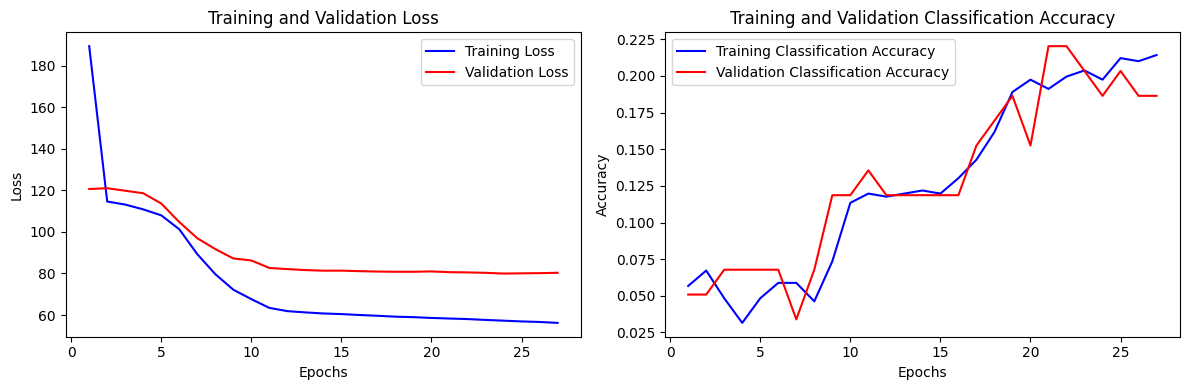

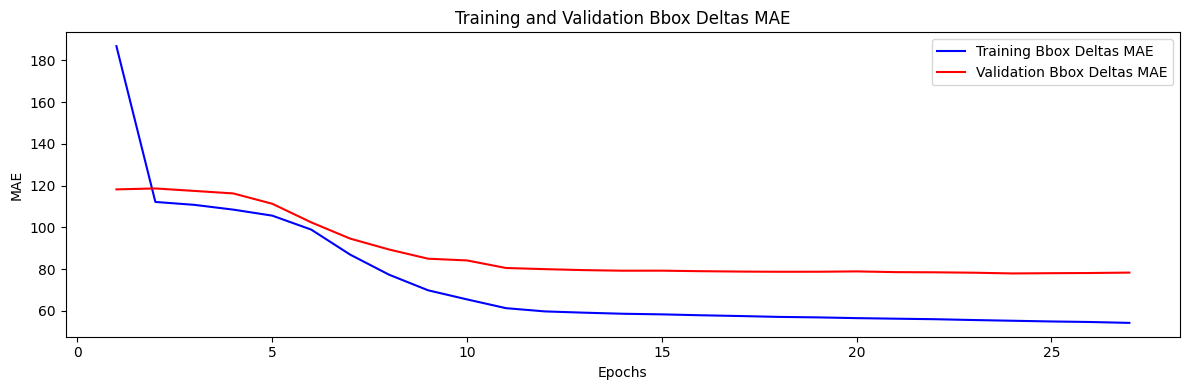

In [30]:
import matplotlib.pyplot as plt

# Extract available training and validation metrics from history object
loss = history.history['loss']
classification_accuracy = history.history['classification_accuracy']
bbox_deltas_mae = history.history['bbox_deltas_mae']
val_loss = history.history['val_loss']
val_classification_accuracy = history.history['val_classification_accuracy']
val_bbox_deltas_mae = history.history['val_bbox_deltas_mae']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation classification accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, classification_accuracy, 'b-', label='Training Classification Accuracy')
plt.plot(epochs, val_classification_accuracy, 'r-', label='Validation Classification Accuracy')
plt.title('Training and Validation Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation bounding box deltas MAE
plt.figure(figsize=(12, 4))
plt.plot(epochs, bbox_deltas_mae, 'b-', label='Training Bbox Deltas MAE')
plt.plot(epochs, val_bbox_deltas_mae, 'r-', label='Validation Bbox Deltas MAE')
plt.title('Training and Validation Bbox Deltas MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
predictions = final_model.predict(test_data)
test_label_predictions, test_bbox_predictions = predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step


In [ ]:
def plot_images_with_bboxes(images, true_bboxes, pred_bboxes):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Plot image
        ax.imshow(images[i])
        ax.axis('off')

        # Plot true bounding box (in red)
        true_bbox = true_bboxes[i]
        ax.add_patch(plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2], true_bbox[3],
                                   edgecolor='r', facecolor='none', linewidth=2))

        # Plot predicted bounding box (in green)
        pred_bbox = pred_bboxes[i]
        ax.add_patch(plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3],
                                   edgecolor='g', facecolor='none', linewidth=2))

    plt.tight_layout()
    plt.show()

num_samples_to_visualize = 4
random_indices = np.random.choice(len(test_data), num_samples_to_visualize, replace=False)

visualize_images = [test_data[idx] for idx in random_indices]
true_bboxes_to_visualize = [test_bboxes[idx] for idx in random_indices]
pred_bboxes_to_visualize = [test_bbox_predictions[idx] for idx in random_indices]

plot_images_with_bboxes(visualize_images, true_bboxes_to_visualize, pred_bboxes_to_visualize)
